# Collection performance prediction

## Individual score analysis

In [1]:
import pandas as pd
import numpy as np
from config.metrics import SIGNATURE_COLUMNS
from utils.general import (aggregate_results, forward_fill_sample_size, 
                           merge_with_model_details, add_transformed_columns)
%load_ext autoreload

directory = "metric_results"
filename = "metrics_corpus"
filetype = ".csv"

# Load data
df = aggregate_results(directory, filename, filetype)

# # Default seed for first runs
df["seed"] = df["seed"].fillna(1234)
df["dataset"] = df["dataset"].str.replace("CQADupstackEnglishRetrieval", "DupstackEnglish")

# Get largest sample experiment
df = forward_fill_sample_size(df, group_cols=["model", "dataset", "seed"])
print(df.seed.value_counts())

# Fill nans
nan_vals = df[SIGNATURE_COLUMNS].isna().sum()
print("Nans: \n", nan_vals[nan_vals > 0])
df[SIGNATURE_COLUMNS] = df[SIGNATURE_COLUMNS].fillna(0)

# Merge with model details
df = merge_with_model_details(df, "config/model_details.yaml")
assert df.architecture.isna().sum() == 0

# Add transformed columns
cols_to_transform = ["mag_area", "twonn_dim", "ph_dim_euclidean", 
                     "recall_at_5", "recall_at_20", "recall_at_100",
                     "ndcg_at_5", "ndcg_at_20", "ndcg_at_100",
                     "map_at_5", "map_at_20", "map_at_100",
                     "main_score", "recall_at_20", "iso_score", 
                     "mag_dim", "recall_at_100", "recall_at_5"]
add_transformed_columns(df, cols_to_transform)

# Exclude certain experiments
print(df.shape)

2026-01-22 08:20:13.395884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769066413.413670 1091288 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769066413.419151 1091288 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769066413.433958 1091288 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769066413.433983 1091288 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769066413.433986 1091288 computation_placer.cc:177] computation placer alr

Loaded dataframe with shape:  (9078, 63)
Forward filled sample sizes. New shape:  (882, 63)
seed
123.0     294
1234.0    294
2025.0    294
Name: count, dtype: int64
Nans: 
 iso_score    24
dtype: int64
(882, 107)


Merge with query space signatures

In [2]:
directory = "metric_results"
filename = "metrics_queries"
filetype = ".csv"

# Load data
df_queries = aggregate_results(directory, filename, filetype, filter_str="_local")
# # Default seed for first runs
df_queries["seed"] = df_queries["seed"].fillna(1234)

# Get largest sample experiment
df_queries = forward_fill_sample_size(df_queries, group_cols=["model", "dataset", "seed"])
print(df_queries.seed.value_counts())

# Merge with model details
df_queries = merge_with_model_details(df_queries, "config/model_details.yaml")
assert df_queries.architecture.isna().sum() == 0
# Add transformed columns
cols_to_transform = ["mag_area", "twonn_dim", "ph_dim_euclidean", 
                     "main_score", "recall_at_20", "iso_score", 
                     "mag_dim", "recall_at_100", "recall_at_5"]
add_transformed_columns(df_queries, cols_to_transform)

# Exclude certain experiments
df_queries = df_queries.reset_index(drop=True)
print(df_queries.shape)

Loaded dataframe with shape:  (2559, 63)
Forward filled sample sizes. New shape:  (882, 63)
seed
123.0     294
1234.0    294
2025.0    294
Name: count, dtype: int64
(882, 95)


In [3]:
df = pd.merge(df, df_queries, on=["model", "dataset", "seed"], how="left", suffixes=("", "_q"))
df.head()

model       dataset    seed  uniformity   
0  Alibaba-NLP/gte-Qwen2-1.5B-instruct       ArguAna   123.0   -2.835543  \
1  Alibaba-NLP/gte-Qwen2-1.5B-instruct       ArguAna  1234.0   -2.835543   
2  Alibaba-NLP/gte-Qwen2-1.5B-instruct       ArguAna  2025.0   -2.835543   
3  Alibaba-NLP/gte-Qwen2-1.5B-instruct  ClimateFEVER   123.0   -2.801040   
4  Alibaba-NLP/gte-Qwen2-1.5B-instruct  ClimateFEVER  1234.0   -2.798660   

   elapsed_time_uniformity  euler_characteristic   
0                15.537313               -1211.0  \
1                20.655431               -1382.0   
2                18.030930               -1353.0   
3                96.622768               -4290.0   
4               152.545961               -4251.0   

   elapsed_time_euler_characteristic  effective_rank   
0                          47.183821      932.163025  \
1                          45.017129      932.163025   
2                          66.512056      932.163025   
3                          46.458248     1013.957764   
4                          45.289764     1013.692871   

   elapsed_time_effective_rank  avg_pair_sim_euclidean  ...   
0                     2.662876                0.454974  ...  \
1                     2.492936                0.454974  ...   
2                     3.255336                0.454974  ...   
3                    26.575716                0.453690  ...   
4                    29.351171                0.453904  ...   

   log_recall_at_20_q  recall_at_20_normalized_q  log_iso_score_q   
0           -0.015053                   1.083393        -2.757570  \
1           -0.015053                   1.083393        -2.757570   
2           -0.015053                   1.083393        -2.757570   
3           -0.596238                   1.473478        -4.166483   
4           -0.596238                   1.473478        -4.166483   

   iso_score_normalized_q  log_mag_dim_q  mag_dim_normalized_q   
0               -0.702963       1.478448              0.382209  \
1               -0.702963       1.478448              0.382209   
2               -0.702963       1.478448              0.382209   
3               -1.426352       1.233508             -2.109250   
4               -1.426352       1.233508             -2.109250   

   log_recall_at_100_q  recall_at_100_normalized_q  log_recall_at_5_q   
0            -0.004279                    0.690986          -0.180336  \
1            -0.004279                    0.690986          -0.180336   
2            -0.004279                    0.690986          -0.180336   
3            -0.336788                    1.356308          -0.960034   
4            -0.336788                    1.356308          -0.960034   

   recall_at_5_normalized_q  
0                  1.023577  
1                  1.023577  
2                  1.023577  
3                  1.583320  
4                  1.583320  

[5 rows x 199 columns]

### Correlation analysis

In [4]:
import plotly.express as px
from utils.analysis import compute_dataset_correlations
from config.metrics import NAME_MAPPING

show = 30
corr_summary = compute_dataset_correlations(df, "recall_at_100_normalized", cols_to_ignore=["model_family",
                                                                                            "training_loss", "architecture",
                                                                                            "model_name_short_q",
                                                                                            "model_family_q",
                                                                                            "training_loss_q", "architecture_q",
                                                                                            "activation",
                                                                                            "activation_q"])
# Extend by query columns
NAME_MAPPING.update({k + "_q": v + " (q)" for k, v in NAME_MAPPING.items()})
corr_summary["metric"] = corr_summary["recall_at_100_normalized vs. "].map(NAME_MAPPING)

fig = px.bar(corr_summary, x="metric", y="mean_abs_corrs", error_y="std_corrs")
fig.update_yaxes(range=[0, 1])
fig.show()

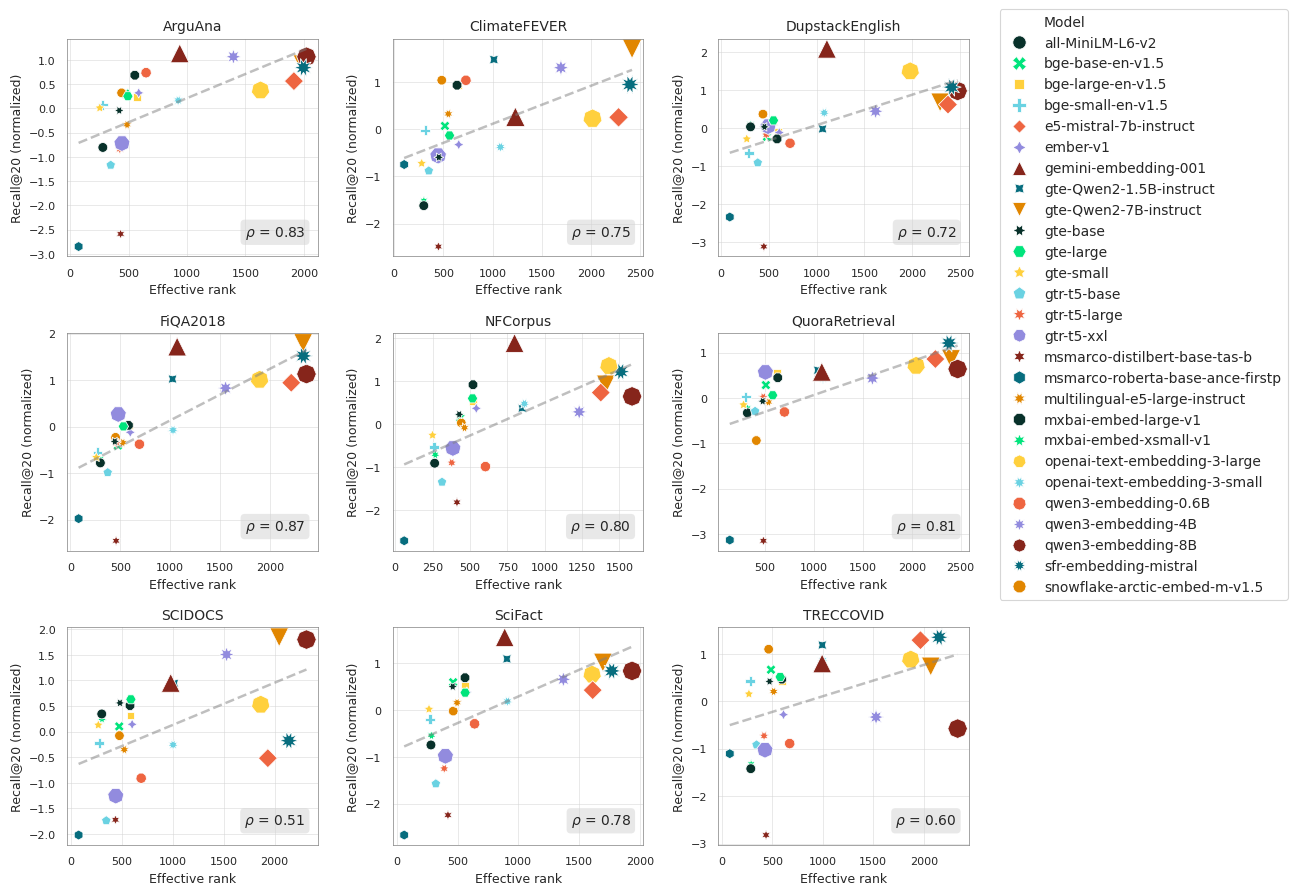

In [6]:
from utils.plotting import plot_dataset_correlations

df["Effective rank"] = df["effective_rank"]
df["Recall@20 (normalized)"] = df["recall_at_20_normalized"]    
subset = df[df["dataset"].isin(['ArguAna', 'DupstackEnglish', 'ClimateFEVER',
                                'FiQA2018', 'NFCorpus', 'QuoraRetrieval', 'SCIDOCS',
                                'SciFact', 'TRECCOVID']) # make symmetric
                                & (df["seed"] == 2025)
                                ]
subset["Model"] = subset["model_name_short"]
plot_dataset_correlations(subset, x="Effective rank", y = "Recall@20 (normalized)",
                            hue = "dataset", style = "Model", size = "model_size",
                            save_name="figures/corr_effective_rank_recall20.pdf",)

In [8]:
from utils.analysis import compute_model_correlations

show = 20
corr_summary = compute_model_correlations(df, "recall_at_100", cols_to_ignore=["model_family",
                                                                                "training_loss", "architecture",
                                                                                "model_name_short_q",
                                                                                "model_family_q",
                                                                                "training_loss_q", "architecture_q",
                                                                                "activation",
                                                                                "activation_q"])
pd.set_option('display.max_rows', show)
corr_summary[corr_summary["mean_abs_corrs"] < 0.9].head(show)

recall_at_100 vs.   mean_abs_corrs  std_corrs
30           ndcg_at_100        0.724726   0.106035
63       log_ndcg_at_100        0.724726   0.106035
106        ndcg_at_100_q        0.706455   0.096133
83             mag_dim_q        0.680408   0.049633
135        log_mag_dim_q        0.680408   0.049633
123       log_mag_area_q        0.667522   0.046654
82            mag_area_q        0.667429   0.046631
87      ph_entr_cosine_q        0.650325   0.041820
100        corpus_size_q        0.646400   0.039883
86   ph_entr_euclidean_q        0.646231   0.039866
91             pca_dim_q        0.623801   0.151696
79      effective_rank_q        0.616322   0.058460
29            ndcg_at_20        0.613455   0.077487
61        log_ndcg_at_20        0.613455   0.077487
133      log_iso_score_q        0.608742   0.114532
90           iso_score_q        0.608742   0.114532
101        sample_size_q        0.596424   0.041804
105         ndcg_at_20_q        0.591103   0.077854
37            main_score        0.558751   0.088695
71        log_main_score        0.558751   0.088695

## Topological signatures analysis

TopoLearn-style Cross-validation

Skipping embedding dimension 1536 with only 2 models
Skipping embedding dimension 3584 with only 1 models
Processing embedding dimension 768 with 8 models and 264 samples
Train Loss (MAE): 0.04802900307585408
Train Loss (MAE): 0.04471062040262155
Train Loss (MAE): 0.05052866552652167
Processing embedding dimension 1024 with 5 models and 165 samples
Train Loss (MAE): 0.022002158301522735
Train Loss (MAE): 0.05047694427987208
Train Loss (MAE): 0.04525471150814228
Processing embedding dimension 384 with 4 models and 132 samples
Train Loss (MAE): 0.02486636976263083
Train Loss (MAE): 0.01631596728818708
Train Loss (MAE): 0.01580047997466577
Skipping embedding dimension 2560 with only 1 models
Processing embedding dimension 4096 with 3 models and 90 samples
Train Loss (MAE): 0.04143801823139618
Train Loss (MAE): 0.03001980016385122
Train Loss (MAE): 0.03587193408045614
Skipping embedding dimension 3072 with only 2 models
Skipping embedding dimension 512 with only 1 models
Processing embeddi

embedding_dimension signature_r2           signature_spearman             
                              mean       std               mean       std   
0                 384    -0.276124  0.387884           0.239786  0.373994  \
1                 768     0.246552  0.148881           0.686805  0.034010   
2                1024    -0.013550  0.232260           0.367035  0.108734   
3                4096    -0.274893  0.477892           0.314485  0.065349   
4                 all     0.380401  0.134061           0.696150  0.105887   

  samples       
     mean  std  
0   132.0  0.0  
1   264.0  0.0  
2   165.0  0.0  
3    90.0  0.0  
4   882.0  0.0

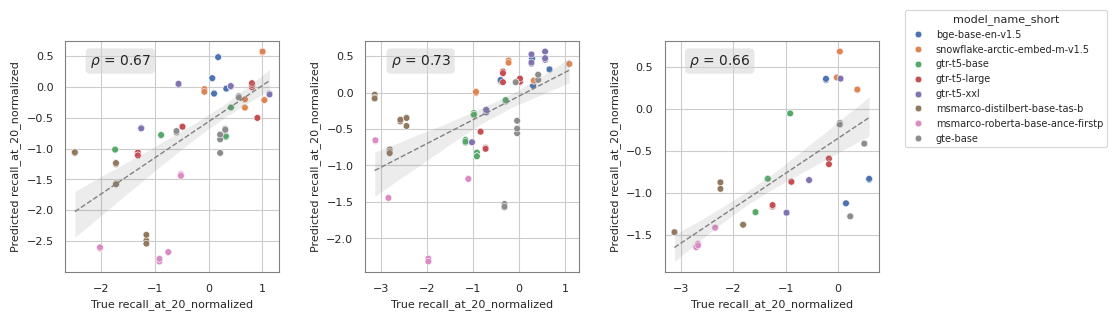

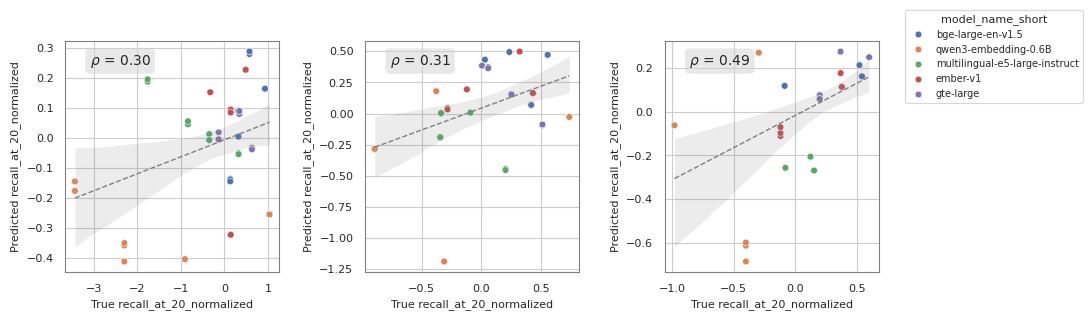

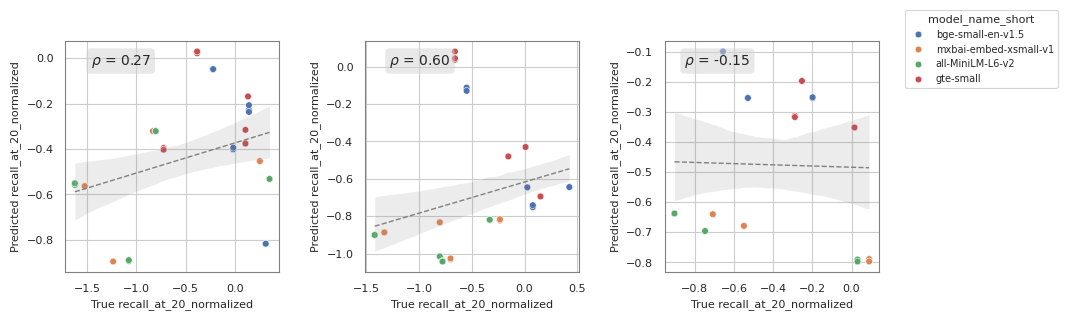

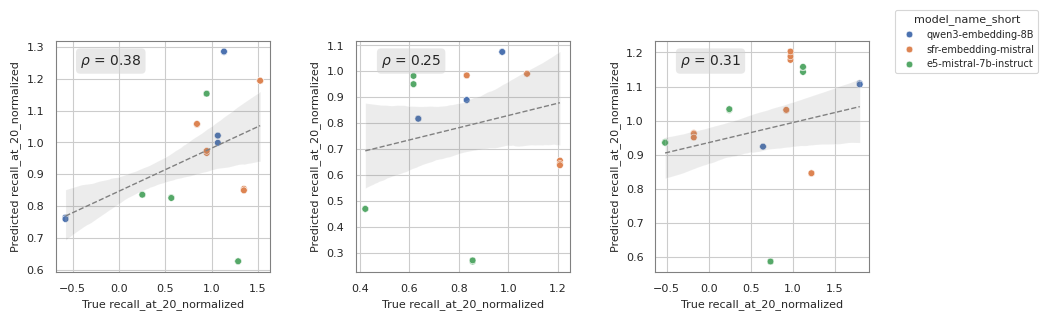

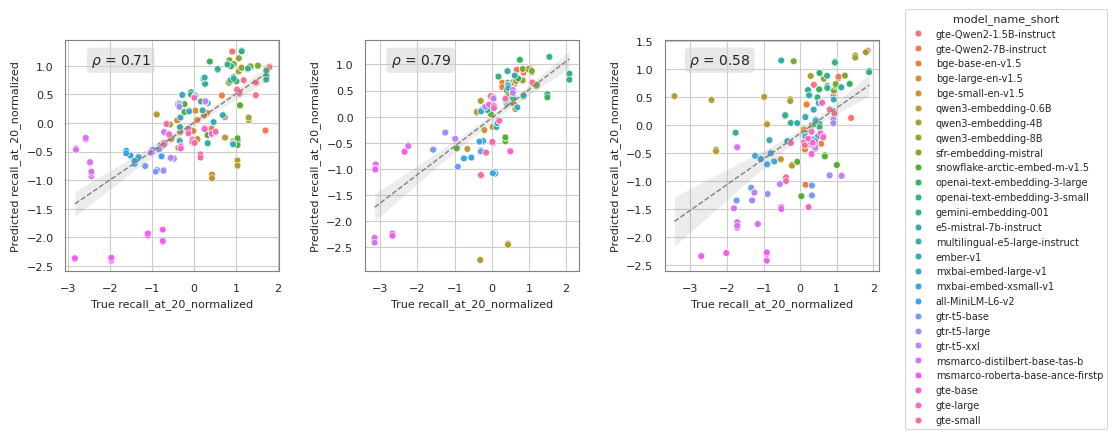

In [19]:
from utils.analysis import signature_predict_cv
from config.metrics import SIGNATURE_COLUMNS

combined_signatures = SIGNATURE_COLUMNS + [col + "_q" for col in SIGNATURE_COLUMNS]

all_results = []
target = 'recall_at_20_normalized'
for embedding_dim in df["embedding_dimension"].unique().tolist() + ["all"]:
    if embedding_dim != "all":
        subset = df[(df["embedding_dimension"] == embedding_dim)]
    else:
        subset = df
    if subset.model.nunique() < 3:
        print(f"Skipping embedding dimension {embedding_dim} with only {subset.model.nunique()} models")
        continue
    print(f"Processing embedding dimension {embedding_dim} with {subset.model.nunique()} models and {subset.shape[0]} samples")
    preds, results = signature_predict_cv(subset, combined_signatures, 
                                        target,
                                        groups=subset['dataset'],
                                        hue="model_name_short", 
                                        normalize_method="mean", 
                                        normalize_axis="all",
                                        baselines=["iso_score", "pca_dim", "avg_pair_sim_euclidean", 
                                                   "mag_area", "embedding_dimension", "model_size",["embedding_dimension", "model_size"],
                                                    "effective_rank"], 
                                        use_pca=False, 
                                        pca_components=5)
    results["embedding_dimension"] = embedding_dim
    results["samples"] = subset.shape[0]
    all_results.append(results)

summary_df = pd.concat(all_results).groupby("embedding_dimension")[["signature_r2", "signature_spearman", "samples"]].agg(['mean', 'std']).reset_index()
summary_df

Disable PCA in the previous cell for the following code

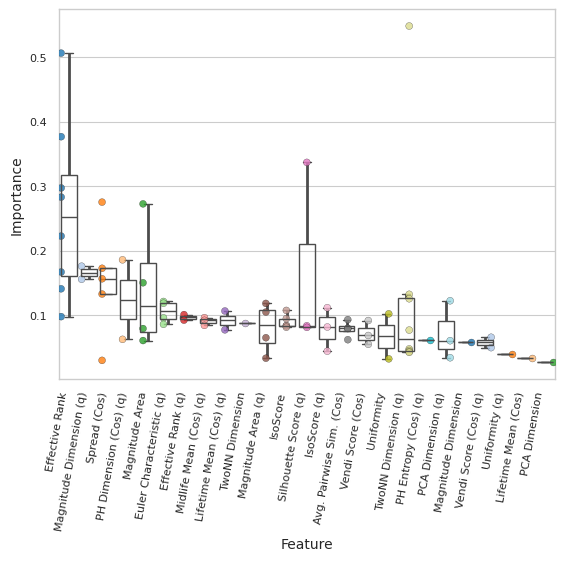

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from config.metrics import NAME_MAPPING

top_features_dfs = pd.concat([pd.concat([pd.DataFrame(i) for i in r["top_features"]]) for r in all_results])
top_features = top_features_dfs.sort_values(by="Importance", ascending=False)
top_features["Metric"] = top_features["Feature"].map(NAME_MAPPING)
NAME_MAPPING_Q = {k + "_q": v + " (q)" for k, v in NAME_MAPPING.items()}
top_features["Metric_q"] = top_features["Feature"].map(NAME_MAPPING_Q)
top_features["Metric"] = top_features["Metric"].fillna(top_features["Metric_q"])

sns.boxplot(
    data=top_features,
    x="Metric",
    y="Importance",
    dodge=True,
    showcaps=True,
    boxprops={'facecolor': 'none', 'zorder': 10},
    showfliers=False,
    whiskerprops={'linewidth': 2},
    linewidth=1,
    order=top_features.groupby("Metric")["Importance"].median().sort_values(ascending=False).index
)

sns.stripplot(
    data=top_features,
    x="Metric",
    y="Importance",
    jitter=0.05,
    dodge=True,
    palette="tab20",
    edgecolor="black",
    linewidth=0.2,
    alpha=0.8,
    order=top_features.groupby("Metric")["Importance"].median().sort_values(ascending=False).index
)

plt.xticks(rotation=80, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Feature", fontsize=10)
plt.ylabel("Importance", fontsize=10)
plt.show()

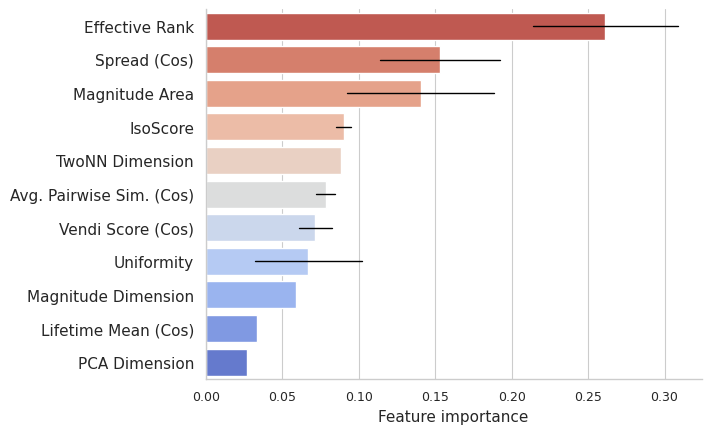

In [21]:
bi = sns.color_palette(["#00E47C", 
                        "#ffd03d",
                        "#6ad2e2",
                        "#ee6541",
                        "#928bde",
                        "#86251b",
                        "#076d7e",
                        "#e18600",
                        "#08312A"])
colors = ["#08312A", "#00E47C"]
palette = sns.blend_palette(colors, n_colors=10, as_cmap=False)

# Drop query features
top_features = top_features[~top_features["Feature"].str.endswith("_q")]
top_10_features = top_features.groupby("Metric")["Importance"].mean().nlargest(15).index

sns.barplot(top_features[top_features["Metric"].isin(top_10_features)], 
            x="Importance", 
            y="Metric", 
            errorbar="se",
            dodge=False,         
            palette="coolwarm_r",      
            edgecolor=None,
            linewidth=1,
            errwidth=1,
            alpha=1, 
            order=top_10_features,
            errcolor='black')
# Rotate labels
plt.ylabel('', fontsize=11)
plt.xlabel('Feature importance', fontsize=11)
plt.yticks(fontsize=11)
sns.despine()
plt.savefig("figures/feature_importance.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

As discussed in the paper - the key factor to predict the retrieval performance lies in the embedding dimension. This can be shown by these baseline experiments.

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

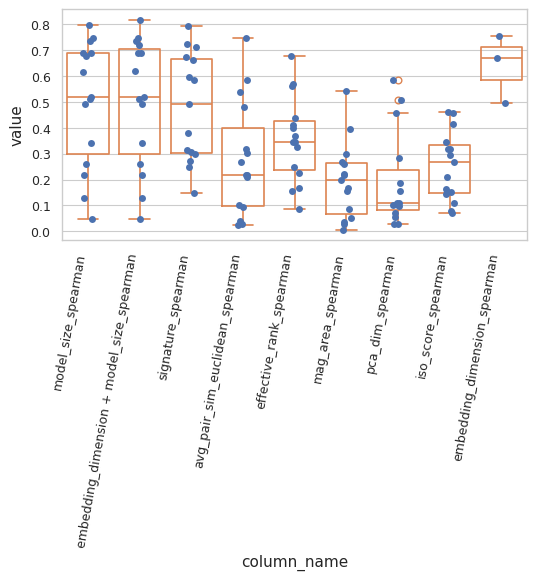

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

all_metrics = []
for results_data in all_results:
    plt.figure(figsize=(6, 3))

    # Only use Spearman
    results_data = results_data.drop([col for col in results_data if "r2" in col] + ["embedding_dimension", "samples", "top_features"], axis=1)
    results_melted = results_data.melt(value_vars=results_data.columns, var_name='column_name', value_name='value')
    results_melted["value"] = np.abs(results_melted["value"])
    results_melted = results_melted.sort_values(by="value", ascending=False)

    all_metrics.append(results_melted)

metrics = pd.concat(all_metrics, ignore_index=True)    
sns.stripplot(metrics, x="column_name", y="value")
sns.boxplot(metrics, x="column_name", y="value", fill=False)
plt.xticks(rotation=80, ha='right')
plt.show()

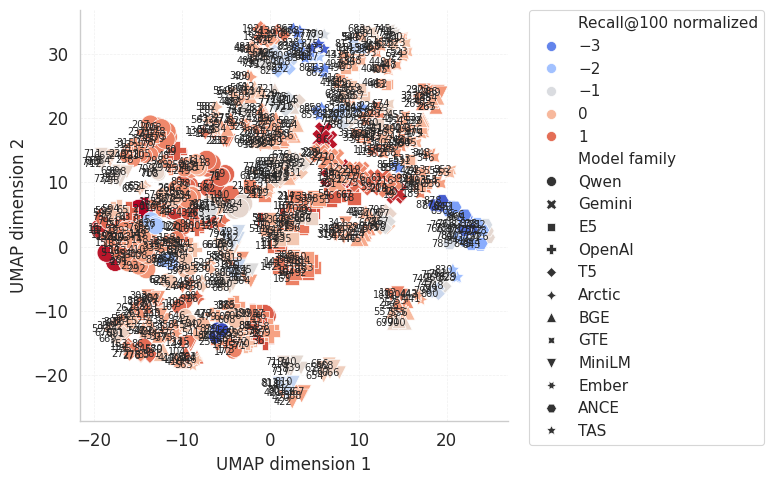

In [25]:
from utils.analysis import create_signature_clusters

color = "Recall@100 normalized" # model_family, recall_at_100_normalized
df["Recall@100 normalized"] = df["recall_at_100_normalized"]
df["Model family"] = df["model_family"]
subset = df[df["dataset"]  == "QuoraRetrieval"]
normalized_df = create_signature_clusters(df, color, 
                                          SIGNATURE_COLUMNS, 
                                          method="umap", 
                                          annotate_idx=True,
                                          shape="Model family",
                                          method_kwargs={"random_state": 123, 
                                                         "n_components": 2, 
                                                         "n_neighbors": 20, 
                                                         'min_dist': 2.5,
                                                         "spread": 2.5
                                                        }, 
                                          normalize_axis="all", 
                                          normalize_method="max",
                                          use_pca=False,
                                          alpha=1,
                                          palette="coolwarm",
                                          save_name="figures/umap_signatures_recall100.pdf")

Use annotate_idx to find out the indices

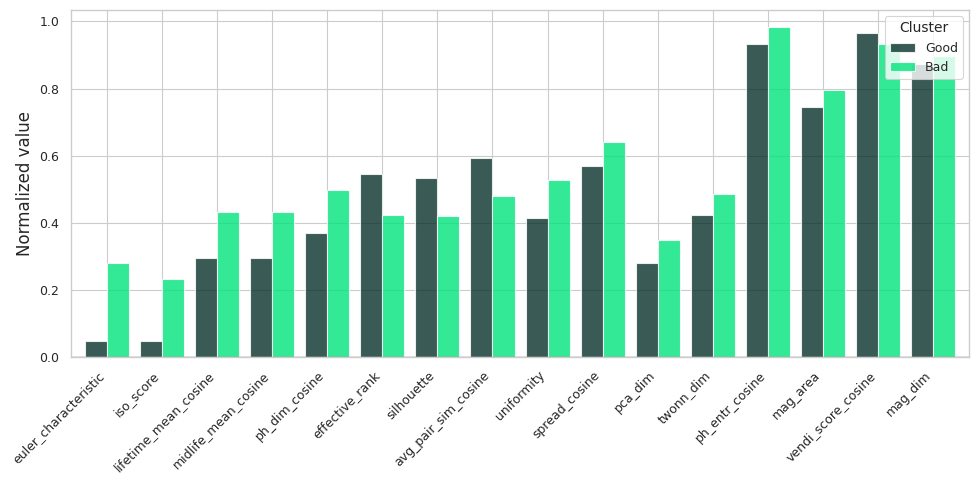

In [24]:
from utils.plotting import plot_cluster_differences


colors= sns.color_palette(["#08312A", 
                            "#00E47C", 
                            "#ffd03d",
                            "#6ad2e2",
                            "#ee6541",
                            "#928bde",
                            "#86251b",
                            "#076d7e",
                            "#e18600"])

# These indices might have changed, use the above plot to pick a few
cluster_1_vals = [0, 22, 19, 77, 14, 213, 117]
cluster_2_vals = [240, 263, 224, 261, 41, 23, 95]

cluster_1 = normalized_df.iloc[cluster_1_vals][SIGNATURE_COLUMNS].mean(axis=0)
cluster_2 = normalized_df.iloc[cluster_2_vals][SIGNATURE_COLUMNS].mean(axis=0)
cluster_df = plot_cluster_differences(cluster_1, cluster_2, colors=colors,
                                      legend_name="Cluster",
                                      cluster_1_name="Good", cluster_2_name="Bad")